In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.cluster import KMeans
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")

In [432]:
df_customer = pd.read_csv("Customer.csv", delimiter=";")
df_product = pd.read_csv("Product.csv", delimiter=";")
df_store = pd.read_csv("Store.csv", delimiter=";")
df_transaction = pd.read_csv("Transaction.csv", delimiter=";")

In [433]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [434]:
df = pd.merge(pd.merge(pd.merge(df_customer, df_transaction, on='CustomerID'), df_product, on='ProductID'), df_store, on='StoreID')
df = df.drop(columns = "Price_y")
df.rename(columns={'Price_x': 'Price'}, inplace=True)
df

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,"5,12",TR54475,23/02/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
1,5,58,1,Married,"3,57",TR53643,22/05/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
2,7,31,0,Married,"4,57",TR5151,10/03/2022,P8,16000,2,32000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
3,19,24,1,Single,"4,14",TR98635,18/06/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4,28,55,0,Married,"6,08",TR9420,12/01/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,403,30,0,Married,"4,06",TR21751,07/10/2022,P9,10000,5,50000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5016,410,55,1,Married,"8,68",TR86692,05/04/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5017,411,19,1,Single,0,TR67993,23/10/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5018,427,54,0,Married,"16,88",TR28578,30/10/2022,P9,10000,3,30000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      5020 non-null   int64 
 1   Age             5020 non-null   int64 
 2   Gender          5020 non-null   int64 
 3   Marital Status  4976 non-null   object
 4   Income          5020 non-null   object
 5   TransactionID   5020 non-null   object
 6   Date            5020 non-null   object
 7   ProductID       5020 non-null   object
 8   Price           5020 non-null   int64 
 9   Qty             5020 non-null   int64 
 10  TotalAmount     5020 non-null   int64 
 11  StoreID         5020 non-null   int64 
 12  Product Name    5020 non-null   object
 13  StoreName       5020 non-null   object
 14  GroupStore      5020 non-null   object
 15  Type            5020 non-null   object
 16  Latitude        5020 non-null   object
 17  Longitude       5020 non-null   object
dtypes: int64

In [436]:
df['Income'] = df['Income'].replace('[,]', '.', regex=True).astype('float')
df['Latitude'] = df['Latitude'].replace('[,]', '.', regex=True).astype('float')
df['Longitude'] = df['Longitude'].replace('[,]', '.', regex=True).astype('float')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

In [437]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      5020 non-null   int64         
 1   Age             5020 non-null   int64         
 2   Gender          5020 non-null   int64         
 3   Marital Status  4976 non-null   object        
 4   Income          5020 non-null   float64       
 5   TransactionID   5020 non-null   object        
 6   Date            5020 non-null   datetime64[ns]
 7   ProductID       5020 non-null   object        
 8   Price           5020 non-null   int64         
 9   Qty             5020 non-null   int64         
 10  TotalAmount     5020 non-null   int64         
 11  StoreID         5020 non-null   int64         
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

### Mengecek dan Mengatasi Missing Value

In [438]:
df.isnull().sum()

CustomerID         0
Age                0
Gender             0
Marital Status    44
Income             0
TransactionID      0
Date               0
ProductID          0
Price              0
Qty                0
TotalAmount        0
StoreID            0
Product Name       0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [439]:
# Membuat array nilai yang tersedia di kolom 'Marital Status'
available_values = df['Marital Status'].dropna().unique()

# Mengganti setiap nilai yang hilang dengan nilai acak dari array nilai yang tersedia
for index, row in df.iterrows():
    if pd.isnull(row['Marital Status']):
        df.at[index, 'Marital Status'] = np.random.choice(available_values)

In [440]:
# Mengecek missing value setelah dilakukan pembersihan
df.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
TransactionID     0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Product Name      0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

### Mengecek dan Mengatasi Data Duplicate

In [441]:
# Mengecek nilai unik dari setiap kolom
df.nunique()

CustomerID         447
Age                 54
Gender               2
Marital Status       2
Income             369
TransactionID     4908
Date               365
ProductID           10
Price               10
Qty                 10
TotalAmount         44
StoreID             14
Product Name        10
StoreName           12
GroupStore           7
Type                 2
Latitude            14
Longitude           14
dtype: int64

In [442]:
df['TransactionID'].value_counts()

TransactionID
TR71313    3
TR74019    2
TR38919    2
TR87715    2
TR54287    2
          ..
TR63136    1
TR11280    1
TR7587     1
TR5274     1
TR28578    1
Name: count, Length: 4908, dtype: int64

In [443]:
# Menghapus data duplikat berdasarkan kolom 'TransactionID', dengan mempertahankan baris terakhir
df.drop_duplicates(subset=['TransactionID'], keep='last', inplace=True)

In [444]:
df['TransactionID'].value_counts()

TransactionID
TR54475    1
TR74254    1
TR95040    1
TR8182     1
TR47837    1
          ..
TR15464    1
TR25829    1
TR29269    1
TR26836    1
TR88485    1
Name: count, Length: 4908, dtype: int64

# **Forecasting**

In [61]:
df_forecast = df.groupby('Date')['Qty'].sum().reset_index()
df_forecast.set_index('Date', inplace=True)
df_forecast

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,43
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


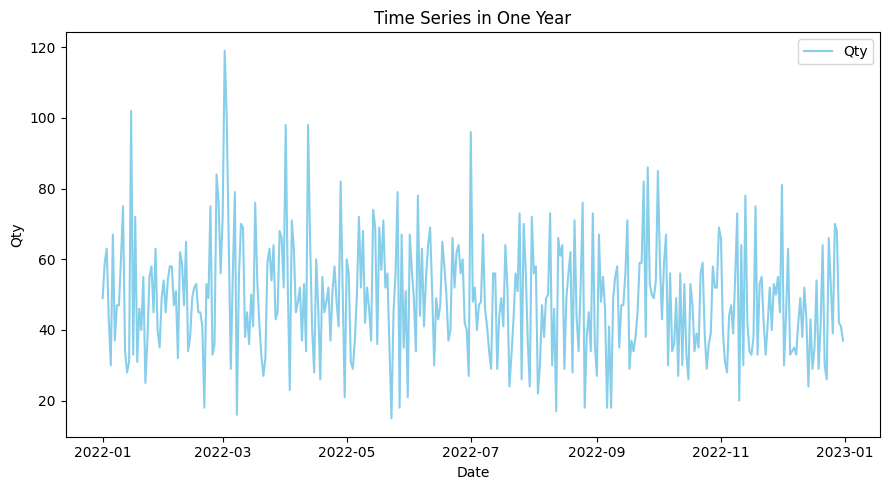

In [62]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df_forecast.index, df_forecast, color='skyblue', label='Qty')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Time Series in One Year')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
# Melakukan uji stasioneritas menggunakan Augmented Dickey-Fuller (ADF) test
result = adfuller(df_forecast)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
  print("\nThe data is stationary")
else:
  print("\nThe data is non-stationary")


ADF Statistic: -19.131655296406304
p-value: 0.0
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393

The data is stationary


<Figure size 1200x600 with 0 Axes>

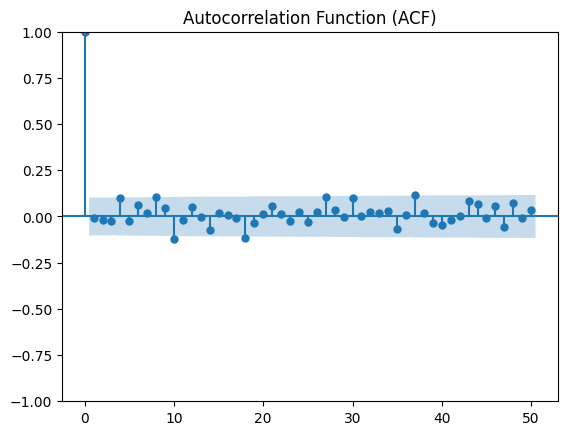

<Figure size 1200x600 with 0 Axes>

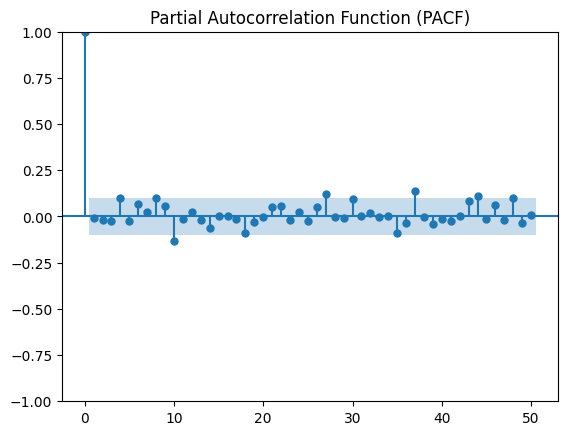

In [64]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df_forecast, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_forecast, lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [65]:
# Membagi dataset menjadi data train dan data test
cut_off = round(df_forecast.shape[0] * 0.8) 
df_train = df_forecast[:cut_off]
df_test = df_forecast[cut_off:]

In [66]:
df_train

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,43
2022-01-05,30
...,...
2022-10-15,33
2022-10-16,26
2022-10-17,53


In [67]:
df_test

,Qty
Date,
2022-10-20,39
2022-10-21,35
2022-10-22,56
2022-10-23,59
2022-10-24,39
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


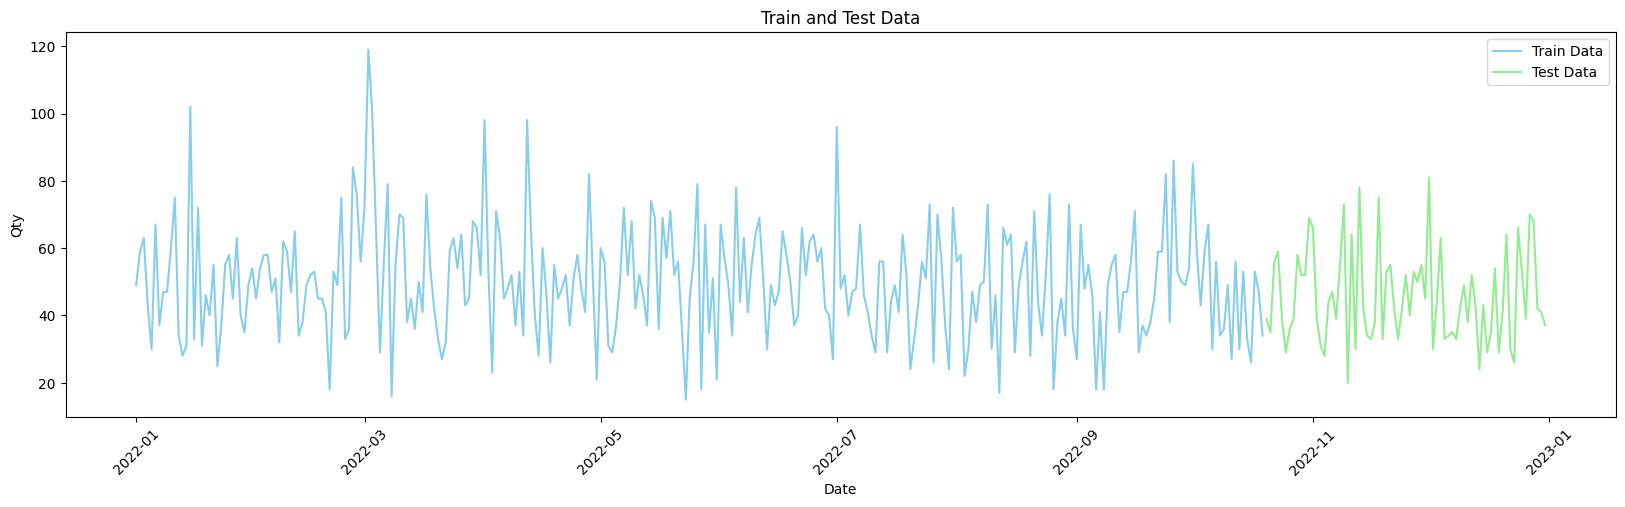

In [68]:
# Plot data train dan data test
plt.figure(figsize=(20, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='skyblue')
plt.plot(df_test.index, df_test, label='Test Data', color='lightgreen')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

## ARIMA

In [69]:
# Membangun model ARIMA dengan parameter yang telah ditetapkan
model = sm.tsa.ARIMA(df_train, order=(4, 0, 8))
model_fit = model.fit()

# Menampilkan ringkasan model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:                 ARIMA(4, 0, 8)   Log Likelihood               -1223.869
Date:                Thu, 16 Nov 2023   AIC                           2475.738
Time:                        07:05:45   BIC                           2527.213
Sample:                    01-01-2022   HQIC                          2496.357
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8212      1.173     42.487      0.000      47.523      52.119
ar.L1          0.1115      0.133      0.839      0.402      -0.149       0.372
ar.L2         -1.3907      0.133    -10.456      0.0

In [ ]:
n_steps = 30
forecast = model_fit.forecast(steps=n_steps)
forecast_data = pd.DataFrame({'ARIMA Forecast': forecast}, index=pd.date_range(start=df_test.index[-1], periods=n_steps+1, freq='D')[1:])

# Simulasi ARIMA
pred = model_fit.get_prediction(start=len(df_forecast), end=len(df_forecast) + n_steps - 1, dynamic=True)
predicted_values = pred.predicted_mean
std_errors = pred.se_mean
residuals = model_fit.resid
simulated_data = np.zeros(n_steps)

for i in range(n_steps):
    simulated_data[i] = predicted_values[i] + np.random.normal(0, std_errors[i]) + residuals[-1]
forecast_data['Simulated ARIMA'] = abs(simulated_data)

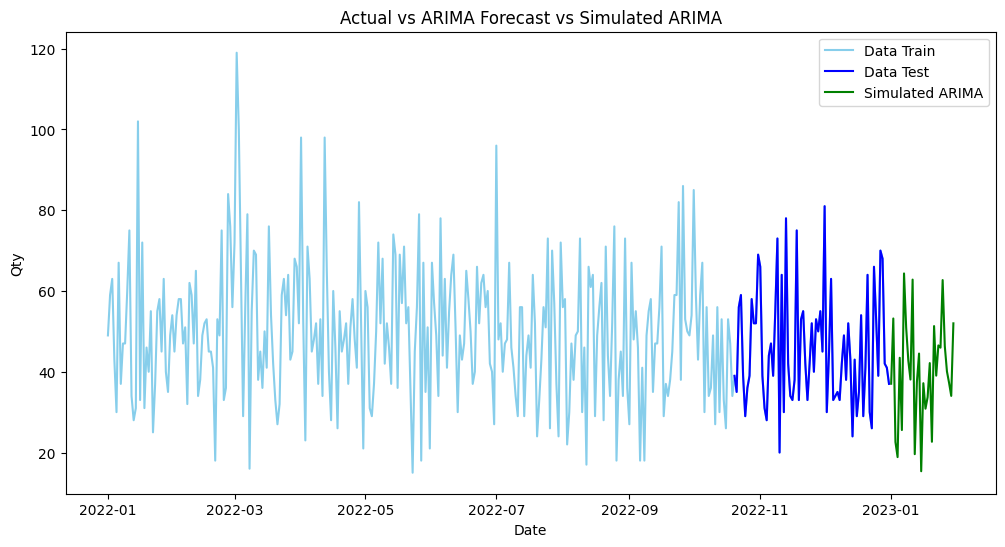

In [268]:
# Plot prediksi ARIMA
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Qty'], label='Data Train', color='skyblue')
plt.plot(df_test.index, df_test['Qty'], label='Data Test', color='blue')
plt.plot(forecast_data.index, forecast_data['Simulated ARIMA'], label='Simulated ARIMA', color='green')
plt.title('Actual vs Simulated ARIMA')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()


# **Clustering**

In [445]:
clustering_data = df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'}).reset_index()
clustering_data = pd.DataFrame(clustering_data)
clustering_data

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,12,56,382300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,15,54,410100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [446]:
clustering_data.nunique()

CustomerID       447
TransactionID     19
Qty               61
TotalAmount      419
dtype: int64

In [447]:
clustering_data = clustering_data.drop(columns='CustomerID', axis=1)
clustering_data

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,12,56,382300
2,15,56,446200
3,10,46,302500
4,7,27,268600
...,...,...,...
442,15,54,410100
443,18,62,577700
444,18,68,587200
445,11,42,423300


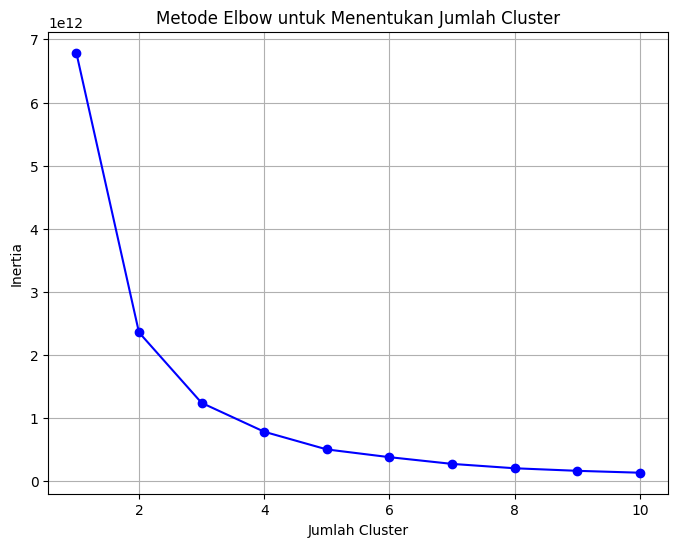

In [448]:
# Menentukan jumlah cluster (gunakan metode Elbow untuk memilih jumlah cluster yang optimal)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method untuk menentukan jumlah cluster yang optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster')
plt.grid(True)
plt.show()

In [449]:
# Menentukan cluster yang paling optimal menggunakan KneeLocator
kl = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing" )
kl.elbow

3

In [450]:
# Membuat 3 cluster
kmeans_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0, n_init = 10)
clusters = kmeans_3.fit_predict(clustering_data)
clustering_data['Cluster'] = clusters
clustering_data.head()

,TransactionID,Qty,TotalAmount,Cluster
0,17,60,623300,1
1,12,56,382300,0
2,15,56,446200,0
3,10,46,302500,2
4,7,27,268600,2


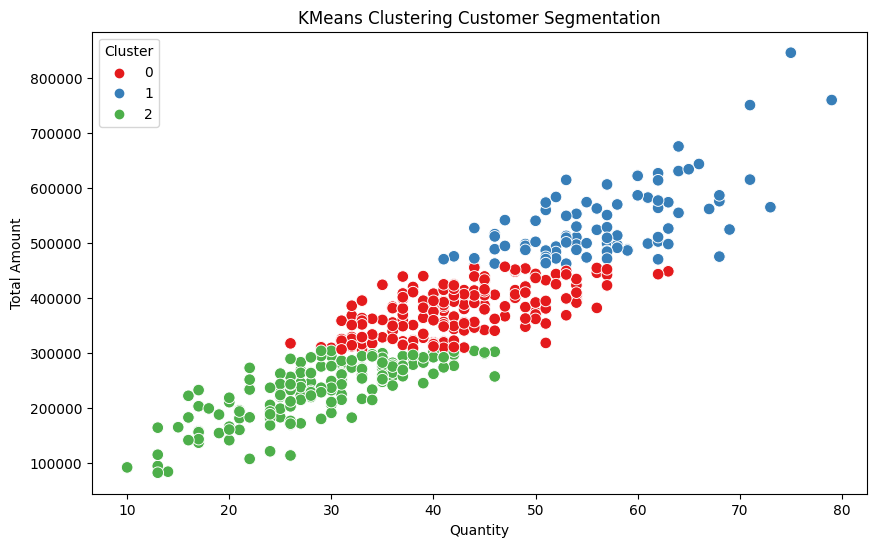

In [452]:
# Menampilkan hasil clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qty', y='TotalAmount', data=clustering_data, hue='Cluster', palette='Set1', s=70)
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.title('KMeans Clustering Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

In [453]:
# Menghitung jumlah data dalam setiap cluster
cluster_counts = clustering_data['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print(cluster_counts)

   Cluster  Count
0        0    187
1        2    172
2        1     88


## Customer Segmentation 

In [454]:
# Menghitung rata-rata Qty dan TotalAmount untuk setiap cluster
cluster_avg = clustering_data.groupby('Cluster').agg({
    'Qty': 'mean',
    'TotalAmount': 'mean'
}).reset_index()

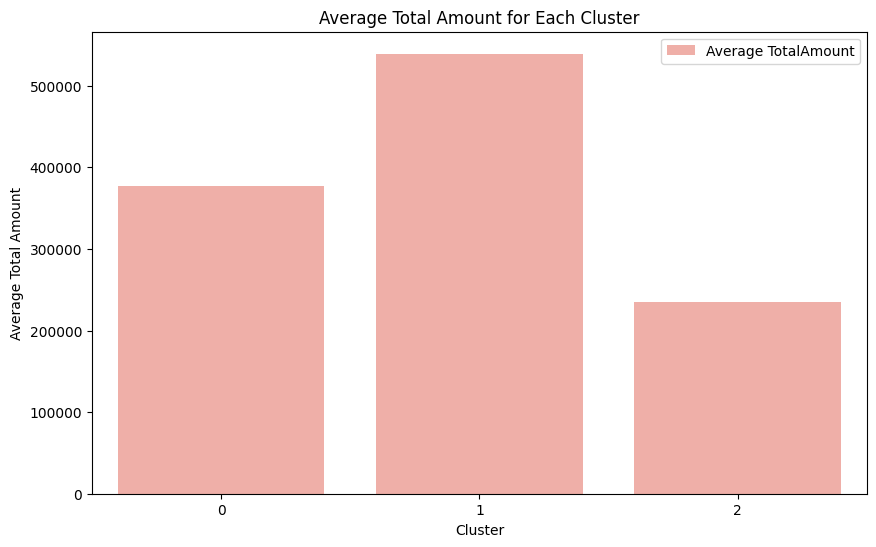

In [455]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='TotalAmount', data=cluster_avg, color='salmon', alpha=0.7, label='Average TotalAmount')
plt.xlabel('Cluster')
plt.ylabel('Average Total Amount')
plt.title('Average Total Amount for Each Cluster')
plt.legend()
plt.show()

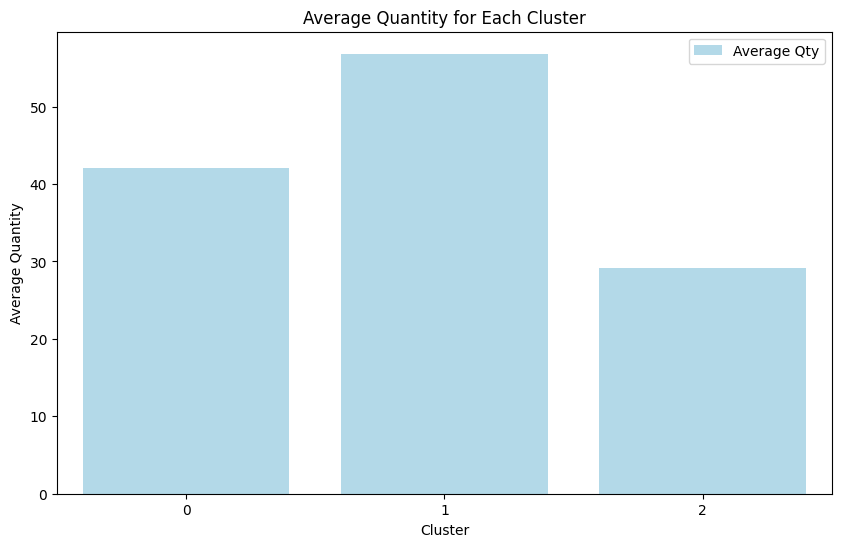

In [456]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Qty', data=cluster_avg, color='skyblue', alpha=0.7, label='Average Qty')
plt.xlabel('Cluster')
plt.ylabel('Average Quantity')
plt.title('Average Quantity for Each Cluster')
plt.legend()
plt.show()

#### **Karakteristik Customer :** 

1. Cluster 1 merupakan "Loyal Customer", hal ini dikarenakan rata-rata dari jumlah pembelian barang dan total pengeluaran nya paling besar.

2. Cluster 0 merupakan "Potential Loyal Customer, hal ini dikarenakan rata-rata dari jumlah pembelian barang dan total pengeluaran nya menengah. 

3. Cluster 2 merupakan "New Customer", hal ini dikarenakan rata-rata dari jumlah pembelian barang dan total pengeluaran nya paling sedikit.

#### **Rekomendasi Bisnis :**

**Cluster 1**

1. Mengembangkan program loyalitas yang menarik, seperti penghargaan poin setiap pembelian, diskon eksklusif, atau akses ke penawaran produk terbatas.

2. Melakukan komunikasi teratur dengan pelanggan melalui email, pesan teks, atau media sosial untuk mempertahankan keterikatan mereka dengan merek.

3. Melakukan survei kepuasan pelanggan secara teratur untuk memahami preferensi mereka dan memastikan kepuasan terus terjaga.

**Cluster 0**

1. Memberikan penawaran yang relevan dan menarik.

2. Mewarkan diskon berbasis pembelian sebelumnya atau program hadiah untuk mendorong pembelian berulang dan membangun loyalitas pelanggan.

3. Memastikan pelayanan pelanggan yang responsif dan ramah, tanggapi pertanyaan atau masukan mereka dengan cepat dan efisien.

**Cluster 2**

1. Memberikan diskon atau hadiah khusus saat pembelian pertama.

2. Melakukan follow-up setelah pembelian pertama, tanyakan tentang pengalaman mereka, dan pastikan bahwa mereka merasa dihargai dan dipedulikan.

3. Menawarkan program loyalitas yang memberikan poin reward setiap kali berbelanja, diskon eksklusif, dan akses ke penawaran khusus untuk member baru.
